# Wannier functions of bcc Fe

## 1. Setup

First import modules and set up the parallel environment

In [2]:

import os
from matplotlib import pyplot as plt
import ray
import scipy
import wannierberri as wberri
import numpy as np

from wannierberri.parallel import Parallel

from pathlib import Path
path_data = Path("../../tests/data/Fe-444-sitesym/")  # adjust path if needed to point to the data in the tests fo wannier-berri repository

results_path = {}
results_grid = {}
include_TR_list = [ True, False, None]  # None means no symmetry

try:
    ray.shutdown()
except:
    pass
parallel = Parallel(ray_init={"num_gpus": 0}) # use of gpus is not tested

# if needed
# os.chdir("path to here")


2024-10-22 16:58:07,662	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


initializing ray with  {'num_gpus': 0, 'num_cpus': None}


/home/stepan/github/wannirrep/.conda/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
/home/stepan/github/wannirrep/.conda/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
2024-10-22 16:58:10,114	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(raylet) [2024-10-22 16:59:10,229 E 241231 241231] (raylet) node_manager.cc:3065: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: b639266d23bc74a6b1497c4c6d10007641152ea0baa4f54eea13a909, IP: 192.168.21.135) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.21.135`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-10-22 17:00:10,230 E 241231 241231] (raylet) node_manager.cc:3065: 1 Workers (tasks / actors) ki

## 2. Wannierise

In [ ]:


w90_data_list = {}

for includeTR in include_TR_list:
    print (f"include_TR = {includeTR}")
    w90data=wberri.w90files.Wannier90data(seedname=str(path_data/"Fe")) 
    # check the symmetries of the amn and eig files
    print (f"eig is symmetric within the accuracy of : {dmn.check_eig(w90data.eig)}")
    print (f"amn is symmetric within the accuracy of : {dmn.check_amn(w90data.amn)}")   
    if includeTR is not None:
        sitesym = True
        dmn = wberri.w90files.DMN(seedname=str(path_data/f"Fe_TR={includeTR}"), read_npz=True)
        w90data.set_file("dmn",dmn)
    else:
        sitesym = False

    #aidata.apply_outer_window(win_min=-8,win_max= 100 )
    froz_max=30
    w90data.wannierise( init = "amn",
                    froz_min=-8,
                    froz_max=froz_max,
                    print_progress_every=10,
                    num_iter=21,
                    conv_tol=1e-6,
                    mix_ratio_z=1.0,
                    localise=True,
                    sitesym=sitesym,
                    )
    
    w90_data_list[includeTR] = w90data




## 3. Create System_w90 objects

In [ ]:

systems = {}
for includeTR in include_TR_list:
    systems[includeTR]=wberri.system.System_w90(w90data= w90data, berry=True, transl_inv_JM=True, transl_inv_MV=False, wcc_phase_fin_diff=False)


## 4. Bands along path

### 4.1 calculate bands

In [34]:
results_path = {}

for includeTR in include_TR_list:
    system = systems[includeTR] 
    # system.set_symmetry(spacegroup=bandstructure.spacegroup)
    tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
                }


    tab_all_path = wberri.calculators.TabulatorAll(
                        tabulators,
                        ibands=np.arange(0,18),
                        mode="path"
                            )

    # all kpoints given in reduced coordinates
    path=wberri.Path(system,
                    k_nodes=[
                        [0.0000, 0.0000, 0.0000 ],   #  G
                        [0.500 ,-0.5000, -0.5000],   #  H
                        [0.7500, 0.2500, -0.2500],   #  P
                        [0.5000, 0.0000, -0.5000],   #  N
                        [0.0000, 0.0000, 0.000  ]
                            ] , #  G
                    labels=["G","H","P","N","G"],
                    length=200 )   # length [ Ang] ~= 2*pi/dk

    results_path[includeTR]=wberri.run(system,
                    parallel=parallel,
                    grid=path,
                    calculators={"tabulate" : tab_all_path},
                    print_Kpoints=False)



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7f161c56a050>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7f16385ab750> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x7f161c56a050>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 215 points and labels {0: 'G', 70: 'H', 130: 'P', 165: 'N', 214: 'G'}
generating K_list
Done 
Done, sum of weights:215.0
processing 215 K poi

/home/stepan/github/wannirrep/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


(pid=229279) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


time for processing    215 K-points on  32 processes:     5.8074 ; per K-point          0.0270 ; proc-sec per K-point          0.8644
time1 =  0.011458396911621094
Totally processed 215 K-points 
run() finished
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7f176d817e50>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7f16c24ba510> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x7f176d817e50>
All calculators are compatible
Symmetrization switc

### 4.2 plot bands

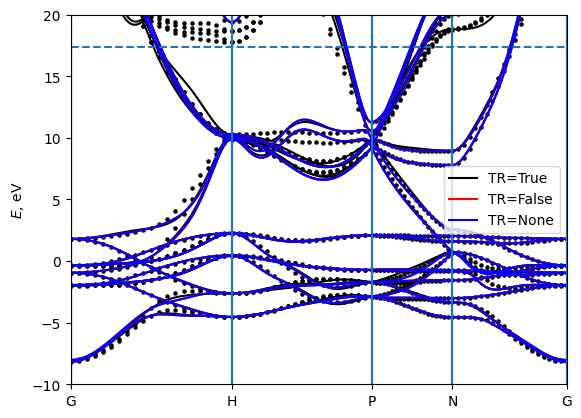

In [35]:

# plot the bands and compare with pw
EF = 12.6

A = np.loadtxt(path_data / "Fe_bands_pw.dat")
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1] = A[:,1] - EF
plt.scatter(A[:,0], A[:,1], c="black", s=5)

colors = ["blue", "red","black"]
for includeTR in include_TR_list:
    path_result = results_path[includeTR].results["tabulate"]

    path_result.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=EF,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor=colors.pop(),
                close_fig=False,
                show_fig=False,
                label=f"TR={includeTR}"
                )

plt.ylim(-10, 20)
plt.hlines(froz_max-EF, 0, A[-1,0], linestyles="dashed")
plt.legend()
plt.savefig("Fe_bands.pdf")


## 5. AHC and Ohmic conductivity

### 5.1 calculate 

In [36]:
results_grid = {}
efermi = np.linspace(12.4,12.8,1001)
param = dict(Efermi=efermi)
calculators_grid = {
     "CDOS": wberri.calculators.static.CumDOS(**param),
                "ohmic": wberri.calculators.static.Ohmic_FermiSea(**param),
                "ahc_internal": wberri.calculators.static.AHC(kwargs_formula={"external_terms":False}, **param),
            "ahc_external": wberri.calculators.static.AHC(kwargs_formula={"internal_terms":False}, **param ),	
}

for includeTR in include_TR_list:
    system = systems[includeTR]
    grid =  wberri.Grid(system, NKFFT=6, NK=48)

    results_grid[includeTR] = wberri.run(system, grid, calculators_grid, 
                                          fout_name="Fe_grid",
                                          suffix = f"TR={includeTR}",
                                          adpt_num_iter=0,
                                          symmetrize=False,  # we do not symmetrize here so that we can chaeck how symmetric are the WFs
                                          use_irred_kpt=False,
                                          print_progress_step=1,
                                          parallel=parallel,
                                          print_Kpoints=False,
                                          )




# plot the bands to compare with pw





Starting run()
Using the follwing calculators : 
############################################################

 'CDOS'  :  <wannierberri.calculators.static.CumDOS object at 0x7f161c4a7650>  : Cumulative density of states
 'ohmic'  :  <wannierberri.calculators.static.Ohmic_FermiSea object at 0x7f161c734990>  : Ohmic conductivity (:math:`S/m`)

        | With Fermi sea integral. Eq(31) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`\sigma_{\alpha\beta} = e^2/\hbar \tau \int [dk] \partial_\beta v_\alpha f`for \tau=1fs| Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta`
 'ahc_internal'  :  <wannierberri.calculators.static.AHC object at 0x7f16c1fdb350>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_

### 5.2 Plot 

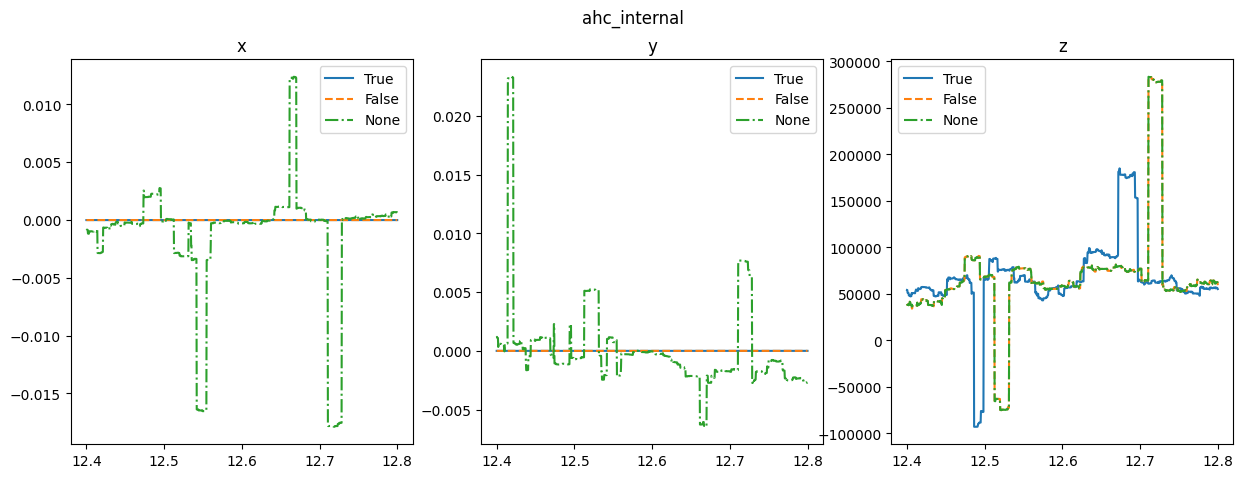

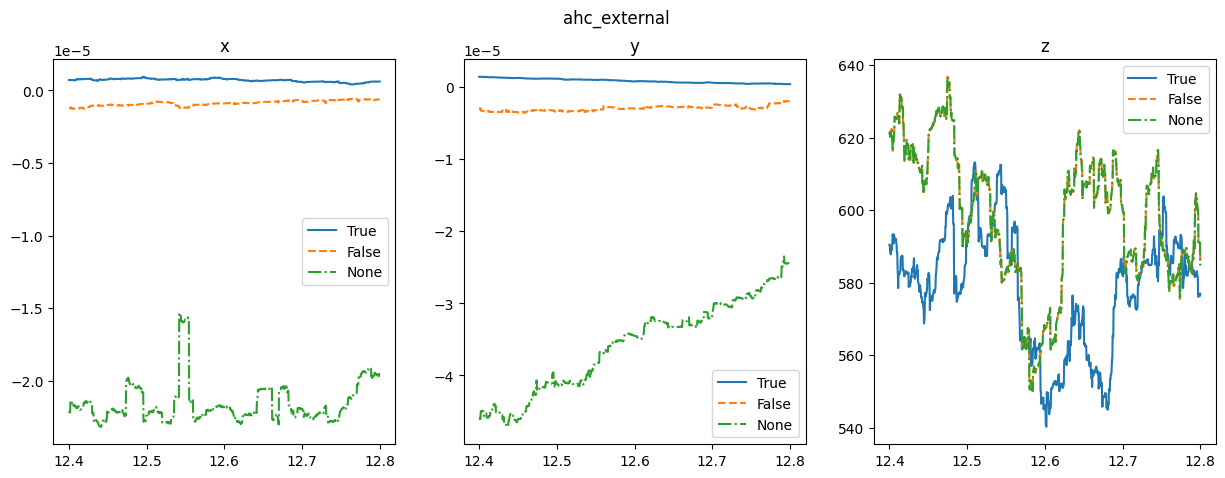

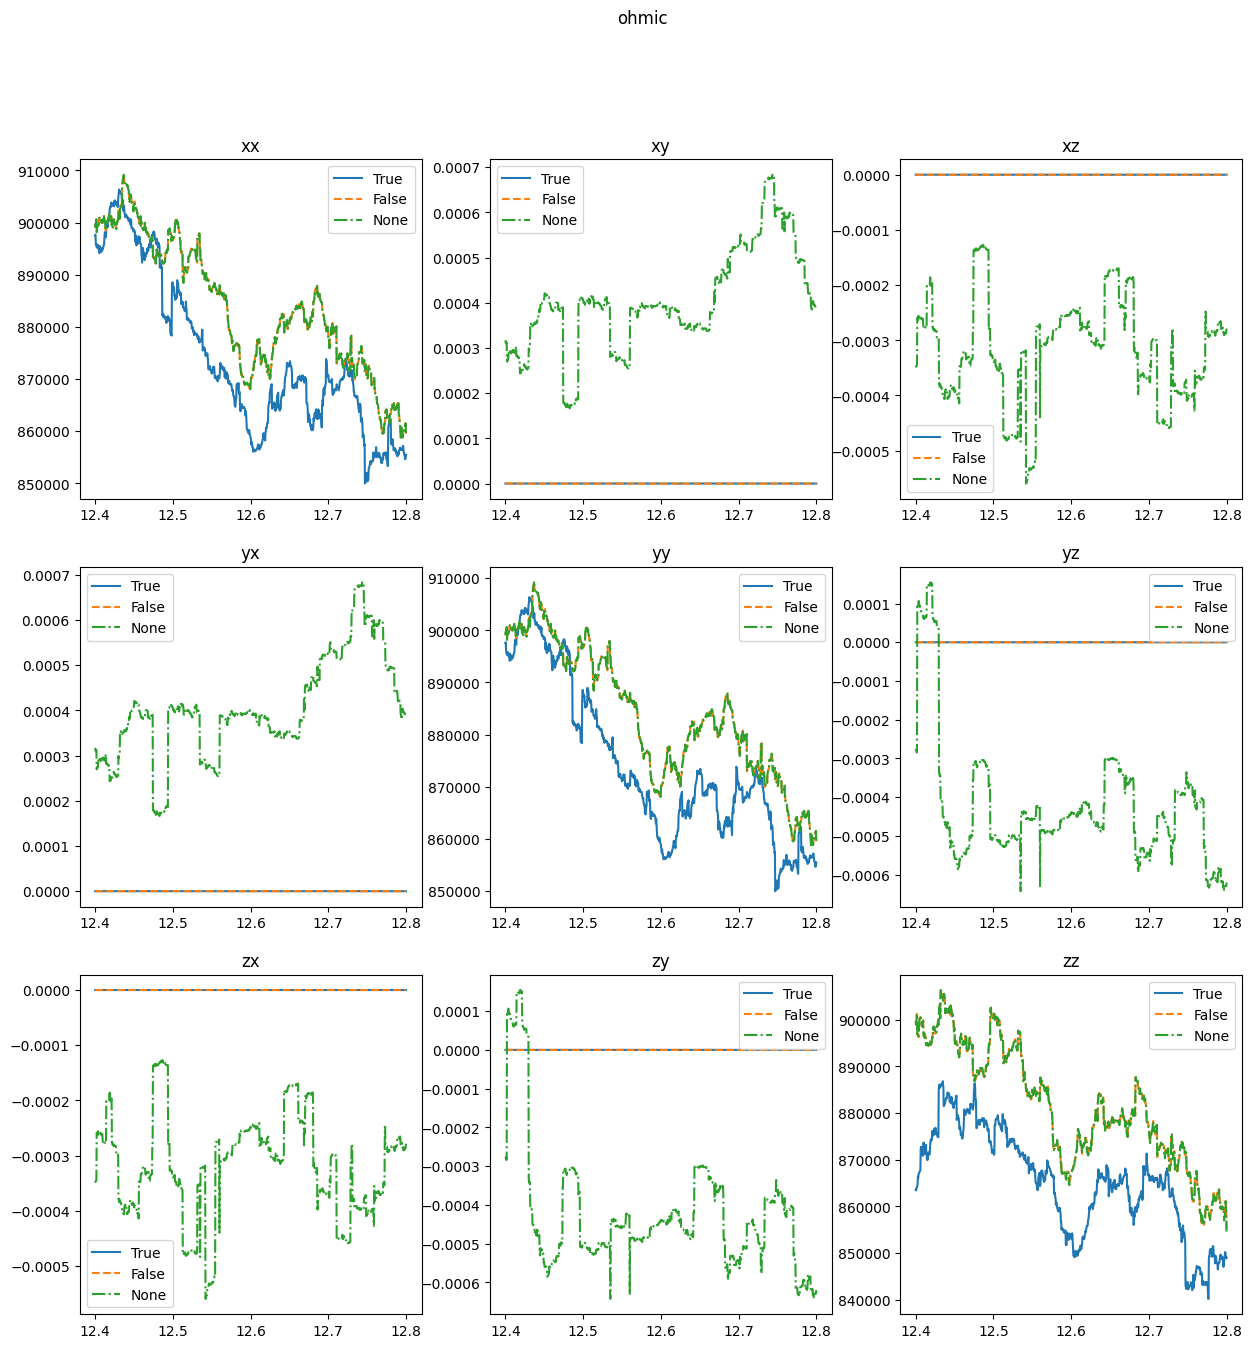

In [38]:
def plotxyz(axes, x, data, pre = "", label="",ls="-"):
    for i in range(3):
        ax =axes[i]
        ax.plot(x, data[:,i], ls, label=label)
        ax.set_title(f"{pre}{'xyz'[i]}")



quantities =  ["ahc_internal", "ahc_external","ohmic"]
linestyles = {k:v for k,v in zip( include_TR_list, ["-", "--", "-."])}
    
nfig = len(quantities)
for quantity in quantities:
    fig = None
    for includeTR in include_TR_list:
        res = results_grid[includeTR].results[quantity]
        data = res.data
        E = res.Energies[0]
        if fig is None:
            if data.ndim == 2:
                nfigx = 1
                nfigy = data.shape[1]
            elif data.ndim == 3:
                nfigx = data.shape[1]
                nfigy = data.shape[2]
            fig, axes = plt.subplots(nfigx, nfigy, figsize=(5*nfigy,5*nfigx))
        if nfigx ==1:
            plotxyz(axes, E, data, label=f"{includeTR}", ls=linestyles[includeTR])
        else:
            for i in range(nfigx):
                plotxyz(axes[i], E, data[:,i], pre="xyz"[i], label=f"{includeTR}", ls=linestyles[includeTR])
    for ax in axes.flat:
        ax.legend()
    fig.suptitle(quantity)
    plt.show()
    plt.close()
    
        


## 6. Creating the dmn files
The `wannierberri.w90files.DMN` class is used to create the dmn files or read them from the disk.
Note that although it can read the files created bt pw2wannier90, and also save in the same format the DMN object contains more information, which is lost when saving to wannier90 format
therefore it is recommended to save the object as npz file, unless you need to use the dmn files with Wannier90 or other codes.

In particular, the DMN object has extra information:

* The matrices D_wann and d_band are stored in block diagonal form, which saves memory and allows for faster calculations.
    - for d_band the blocks correspond to (almost) degenerate bands
    - for D_wann the blocks correspond to the same orbital at the same Wyckoff position
* The information on magnetic symmeties (which symmetry operation includes time reversal)

### 6.1 read the bandstructure using irrep

In [22]:

from irrep.bandstructure import BandStructure
path_data = Path("../../tests/data/Fe-222-pw/")  # adjust path if needed to point to the data in the tests fo wannier-berri repository
bandstructure = BandStructure(code='espresso',   # to work with VASP or abinit please refer to the documentation of irrep
                            prefix=str(path_data / "Fe"),
                            Ecut=100,
                            normalize=False,
                            magmom=[[0,0,1]],  # set the magnetic moments for a magnetic system (units do not matter)
                            include_TR=True)  # set include_TR=False if you do not want to include the symmetries involving time reversal
bandstructure.spacegroup.show()
dmn = wberri.w90files.DMN(empty=True)
dmn.from_irrep(bandstructure)





 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       |      Vectors of REF. cell      
a0 =  1.4350   1.4350   1.4350  |  a0 =  1.4350  -1.4350  -1.4350
a1 = -1.4350   1.4350   1.4350  |  a1 =  1.4350   1.4350  -1.4350
a2 = -1.4350  -1.4350   1.4350  |  a2 =  1.4350   1.4350   1.4350

Atomic positions in direct coordinates:

Atom type |   Position in DFT cell    |   Position in REF cell   
    1     |  0.0000   0.0000   0.0000 |  0.0000   0.0000   0.0000


 ---------- SPACE GROUP ----------- 


Space group: magnetic-unknown (# None)
Number of symmetries: 16 (mod. lattice translations)

The transformation from the DFT cell to the reference cell of tables is given by: 
        |   1.0000  0.0000  0.0000 |
refUC = |   0.0000  1.0000  0.0000 |    shiftUC = [0. 0. 0.]
        |   0.0000  0.0000  1.0000 |


 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1

### Set projections

In [ ]:

# now set the transformations of WFs. Make sure, the projections are consistent with the amn file
pos = [[0,0,0]]
dmn.set_D_wann_from_projections(projections=[(pos, 's'), (pos,'p'), (pos,'d')])

#write on disk
dmn.to_npz("Fe_spd.dmn.npz")

# later can be read with
dmn_read_npz = wberri.w90files.DMN(seedname="Fe_spd", read_npz=True)

# or write to w90 file (wiss not work if include_TR is True)
#dmn.to_w90_file("Fe_spd")
#dmn_read_w90 = wberri.w90files.DMN(seedname="Fe_spd", read_npz=False)



In [19]:
%ls

Fe_spd.dmn  Fe_spd.dmn.npz  wannierise.ipynb


/home/stepan/github/wannirrep/.conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
